In this notebook we'll develop some functionality to determine bid and ask from the trade history. First, we'll do our imports and bring over the relevant functionality from the previous notebook.

In [1]:
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from old_utils import get_trades, get_trades_by_instrument


We're going to analyze last week (week of 13 October) and get a picture of the spreads on the option chain expiring 17 Oct, or other expiries. First, we need to extract a list of strikes traded for that date.

In [2]:
start_time = int(datetime(2025, 10, 13).timestamp() * 1000)
end_time = int(datetime(2025, 10, 18).timestamp() * 1000)
df = get_trades("BTC", "option", start_timestamp=start_time, end_timestamp=end_time)
print(f"{len(df)} trades")
print(f"datetime of first trade: {datetime.fromtimestamp(df['timestamp'].iloc[0]/1000)}")
print(f"datetime of last trade: {datetime.fromtimestamp(df['timestamp'].iloc[-1]/1000)}")

print(f"\nUnique instruments ({df['instrument_name'].nunique()}):")
for instrument in sorted(df['instrument_name'].unique()):
    print(f"  - {instrument}")

Fetching BTC option trades:   0%|          | 0.00/432M [00:00<?, ?it/s]

✓ Completed 11 API fetches
✓ Dropped 12 duplicate trade(s)
107599 trades
datetime of first trade: 2025-10-13 00:00:03.615000
datetime of last trade: 2025-10-17 23:59:23.458000

Unique instruments (854):
  - BTC-13OCT25-102000-P
  - BTC-13OCT25-105000-P
  - BTC-13OCT25-106000-P
  - BTC-13OCT25-107000-P
  - BTC-13OCT25-108000-P
  - BTC-13OCT25-109000-P
  - BTC-13OCT25-110000-P
  - BTC-13OCT25-111000-C
  - BTC-13OCT25-111000-P
  - BTC-13OCT25-112000-C
  - BTC-13OCT25-112000-P
  - BTC-13OCT25-113000-C
  - BTC-13OCT25-113000-P
  - BTC-13OCT25-114000-C
  - BTC-13OCT25-114000-P
  - BTC-13OCT25-115000-C
  - BTC-13OCT25-115000-P
  - BTC-13OCT25-116000-C
  - BTC-13OCT25-116000-P
  - BTC-13OCT25-117000-C
  - BTC-13OCT25-117000-P
  - BTC-13OCT25-118000-C
  - BTC-13OCT25-119000-C
  - BTC-13OCT25-120000-P
  - BTC-13OCT25-121000-C
  - BTC-13OCT25-121000-P
  - BTC-13OCT25-122000-C
  - BTC-13OCT25-123000-P
  - BTC-14OCT25-100000-P
  - BTC-14OCT25-102000-P
  - BTC-14OCT25-103000-P
  - BTC-14OCT25-104000

Next, we'll look at what prices most trades are at. Are traders avoiding the 12.5% fees?

In [45]:
# Get descriptive statistics of trade prices
print("Trade Price Statistics:")
print(df['price'].describe())

print("Fee analysis per trade:")
# Calculate fee as percentage of option price based on min(0.0003 BTC, 0.125 * OptionPrice)
df['fee_pct'] = df.apply(lambda x: (min(0.0003, 0.125 * x['price']) / x['price']) * 100, axis=1)

print("\nFee Statistics (as % of option price):")
print(df['fee_pct'].describe())

df.drop(columns=['fee_pct'], inplace=True)

Trade Price Statistics:
count    85609.000000
mean         0.023821
std          0.050433
min          0.000100
25%          0.002600
50%          0.009500
75%          0.026500
max          1.196500
Name: price, dtype: float64
Fee analysis per trade:

Fee Statistics (as % of option price):
count    85609.000000
mean         5.279320
std          4.749415
min          0.025073
25%          1.132075
50%          3.157895
75%         11.538462
max         12.500000
Name: fee_pct, dtype: float64


It looks like they are, but the fee is still quite significant for combos with trading activity. With fees commonly well above 1%, profitable market making is probably quite difficult, which would explain why high spreads are observed.

Let's see which expiries have significant volume in this period:

In [80]:
# Extract expiry date from instrument name and group by it
df['expiry'] = df['instrument_name'].str.extract(r'BTC-(\d+[A-Z]+\d+)-\d+-[CP]')[0]
volume_by_expiry = df.groupby('expiry')['amount'].sum().sort_values(ascending=False)
value_by_expiry = (df['amount'] * df['price']).groupby(df['expiry']).sum().sort_values(ascending=False)

print("Top 10 expiries by trading volume (contracts):")
for expiry, volume in volume_by_expiry.head(10).items():
    value = value_by_expiry[expiry]
    print(f"  {expiry}: {volume:.0f} contracts (value: {value:.4f} BTC)")


Top 10 expiries by trading volume (contracts):
  31OCT25: 74225 contracts (value: 1471.0484 BTC)
  24OCT25: 43912 contracts (value: 817.4539 BTC)
  26DEC25: 41524 contracts (value: 1628.5313 BTC)
  17OCT25: 36313 contracts (value: 443.0213 BTC)
  28NOV25: 31723 contracts (value: 1061.7171 BTC)
  18OCT25: 18626 contracts (value: 120.8277 BTC)
  14OCT25: 10941 contracts (value: 42.7780 BTC)
  15OCT25: 9760 contracts (value: 40.2978 BTC)
  16OCT25: 8646 contracts (value: 28.8490 BTC)
  7NOV25: 8250 contracts (value: 189.3724 BTC)


In [82]:
# Filter df for just 31OCT25 expiry
expiry_date = '31OCT25'
filtered_df = df[df['instrument_name'].str.contains(expiry_date)].copy().reset_index(drop=True)
filtered_df.loc[:, 'strike'] = filtered_df['instrument_name'].str.extract(f'{expiry_date}-(\\d+)-[CP]').astype(int)
filtered_df.loc[:, 'option_type'] = filtered_df['instrument_name'].str.extract(f'{expiry_date}-\\d+-([CP])')
filtered_df = filtered_df.drop(['combo_trade_id', 'combo_id', 'block_trade_leg_count', 'block_trade_id', 'block_rfq_id', 'liquidation'], axis=1)

print(f"Filtered to {len(filtered_df)} trades for {expiry_date} expiry")
print(f"First trade: {datetime.fromtimestamp(filtered_df['timestamp'].iloc[0]/1000)}")
print(f"Last trade: {datetime.fromtimestamp(filtered_df['timestamp'].iloc[-1]/1000)}")

# Get unique strikes for that expiry
unique_strikes = filtered_df['strike'].drop_duplicates().sort_values()

print(f"\n{len(unique_strikes)} unique strike prices for {expiry_date} found.")
print(f"Strike range: ${min(unique_strikes):,} to ${max(unique_strikes):,}")


Filtered to 19085 trades for 31OCT25 expiry
First trade: 2025-10-13 00:00:04.326000
Last trade: 2025-10-17 23:58:07.748000

53 unique strike prices for 31OCT25 found.
Strike range: $40,000 to $210,000


Now We'll examine the trade volume and value traded throughout the week for this expiry

First trade: 2025-10-12 23:00:04.326000
Last trade: 2025-10-17 22:58:07.748000
Time span: 4 days 23:58:03.422000


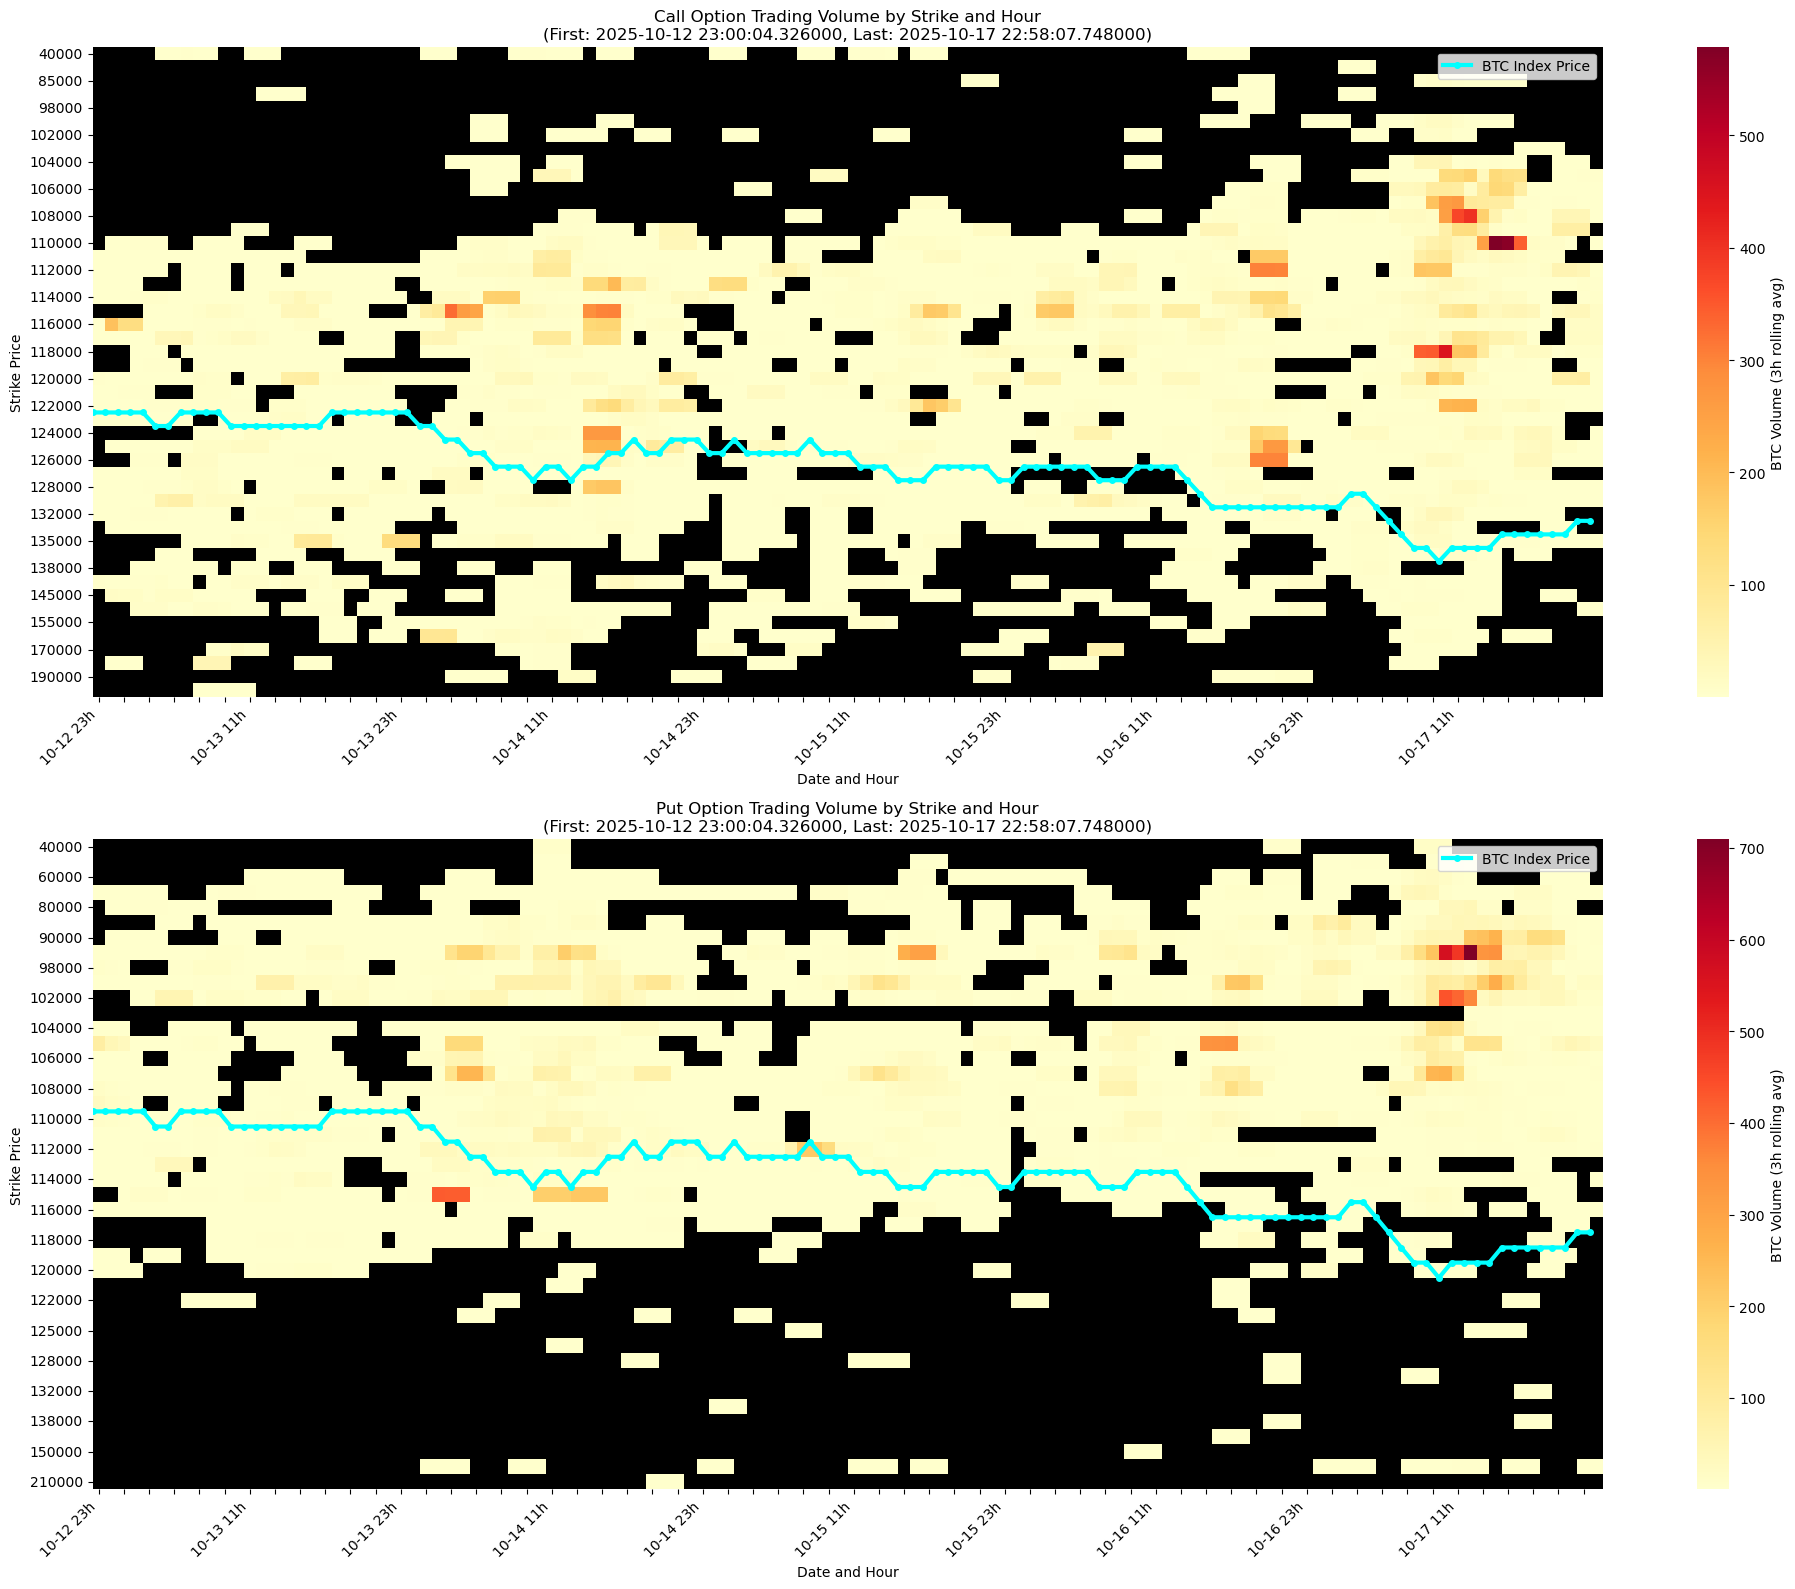

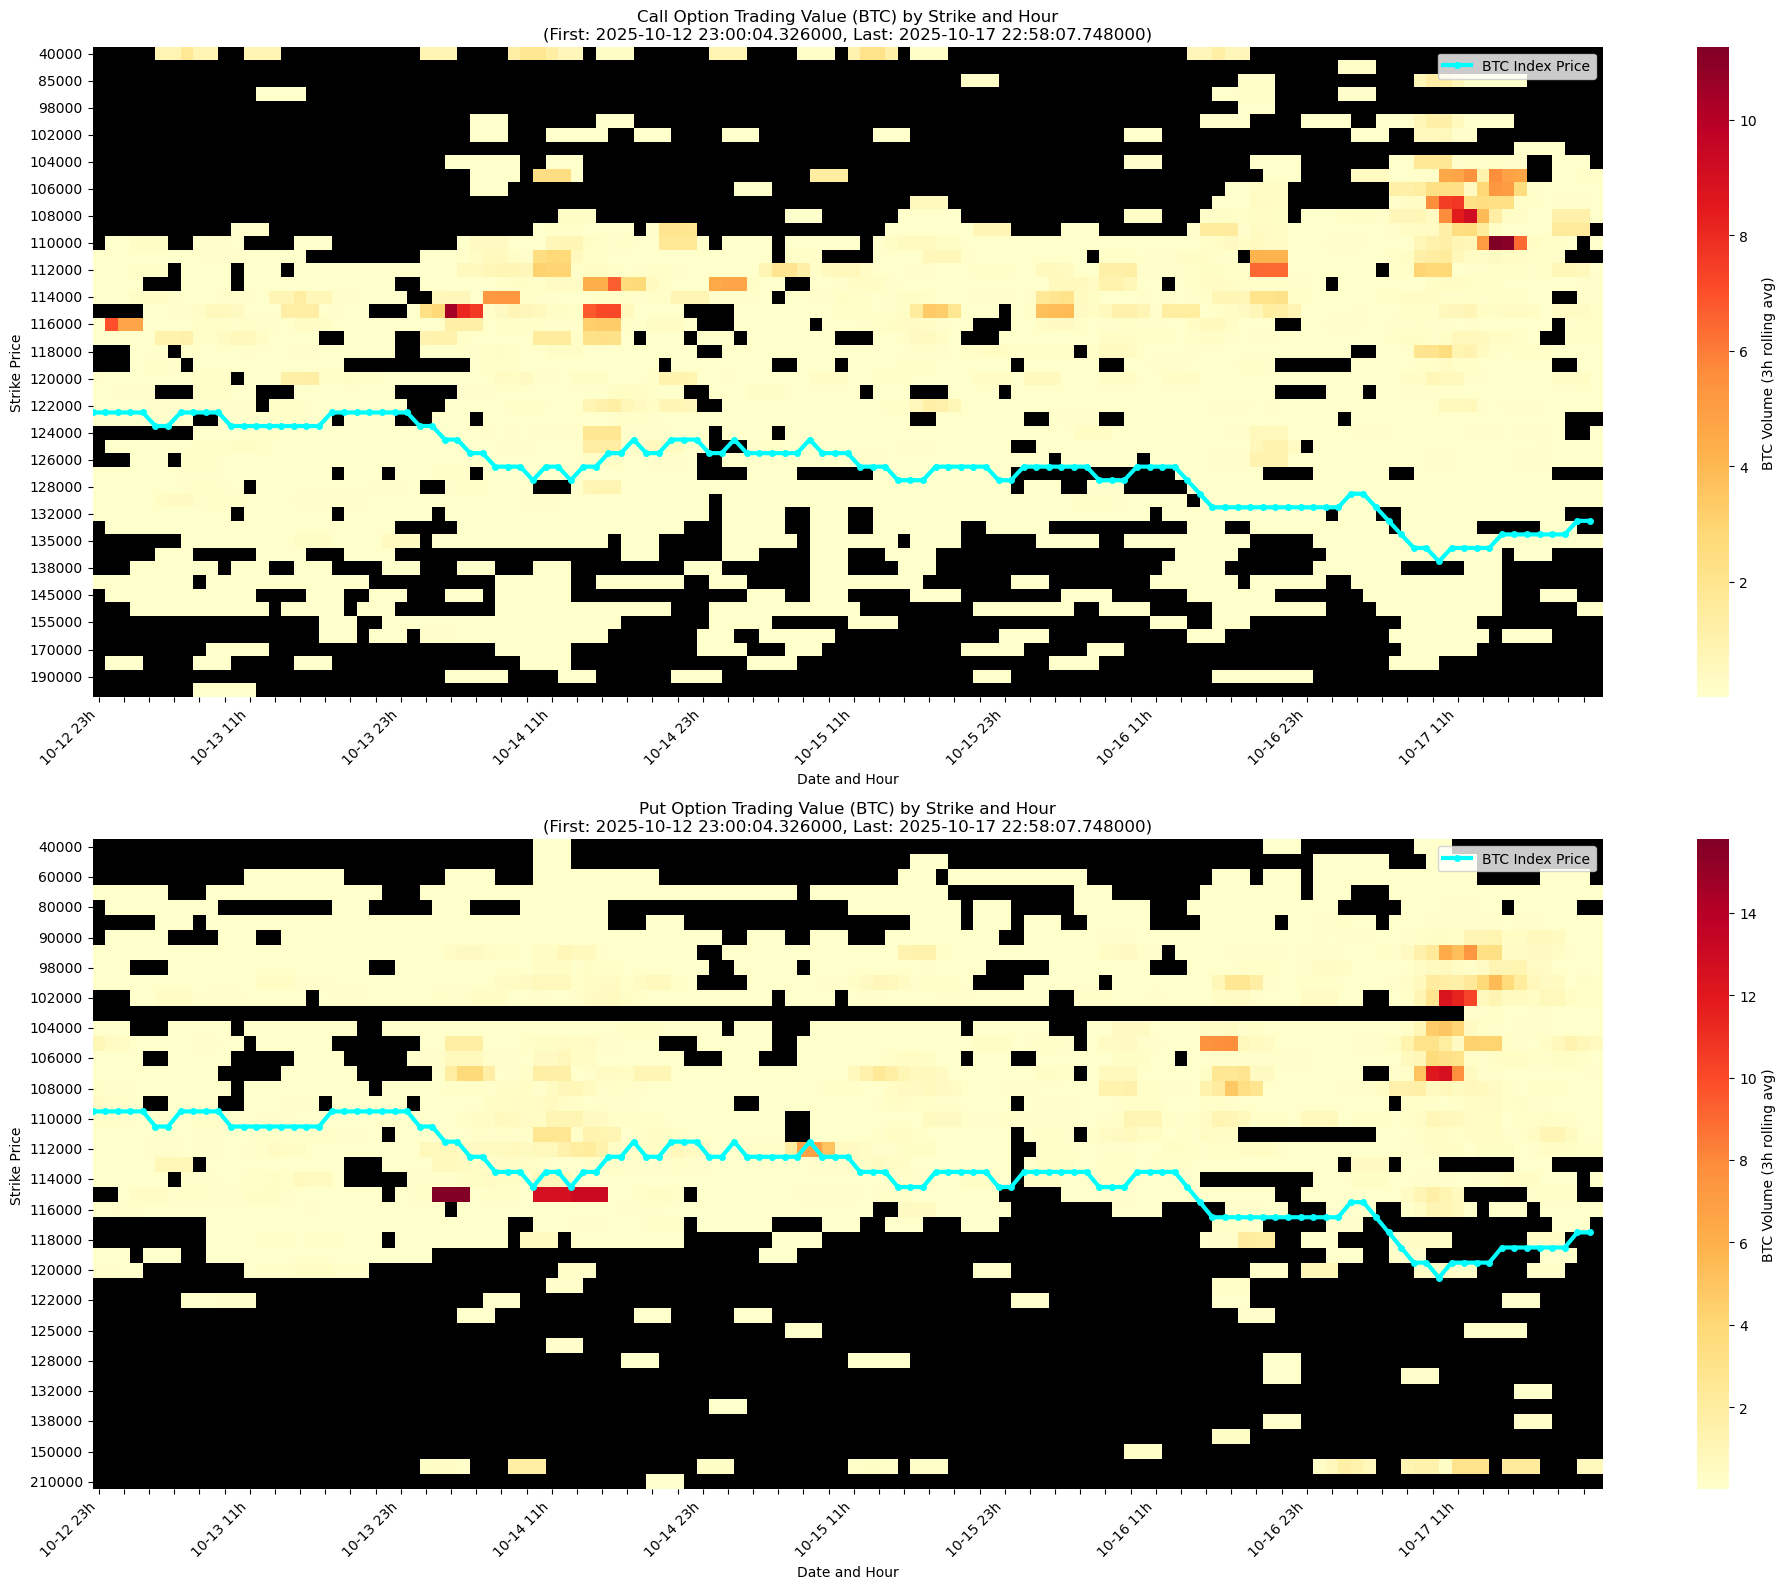

In [83]:
# Create separate dataframes for calls and puts
filtered_df['datetime'] = pd.to_datetime(filtered_df['timestamp'], unit='ms')
calls_df = filtered_df[filtered_df['option_type'] == 'C'].copy()
puts_df = filtered_df[filtered_df['option_type'] == 'P'].copy()

# Get first and last trade times to set bounds
first_trade = filtered_df['datetime'].min()
last_trade = filtered_df['datetime'].max()

print(f"First trade: {first_trade}")
print(f"Last trade: {last_trade}")
print(f"Time span: {last_trade - first_trade}")

def create_volume_pivot(df):
    """Create hourly volume pivot table with 3-hour rolling average"""
    df['hour'] = df['datetime'].dt.floor('h')
    pivot = pd.pivot_table(df, values='amount', index='strike',
                          columns='hour', aggfunc='sum', fill_value=0)
    rolling = pivot.T.rolling(window=3, min_periods=1).mean().T
    rolling.columns = rolling.columns.strftime('%m-%d %Hh')
    return rolling

def create_value_pivot(df):
    """Create hourly traded value pivot table with 3-hour rolling average"""
    df['hour'] = df['datetime'].dt.floor('h')
    df['traded_value'] = df['amount'] * df['price']  # Calculate BTC value of trades
    pivot = pd.pivot_table(df, values='traded_value', index='strike',
                          columns='hour', aggfunc='sum', fill_value=0)
    rolling = pivot.T.rolling(window=3, min_periods=1).mean().T
    rolling.columns = rolling.columns.strftime('%m-%d %Hh')
    return rolling

def create_heatmap(rolling_data, ax, title, index_price_hourly, first_trade, last_trade):
    """Create heatmap with index price overlay"""
    import numpy as np
    
    # Create custom colormap from yellow to orange
    custom_cmap = sns.color_palette("YlOrRd", as_cmap=True)
    
    # Create mask for zero values
    mask = rolling_data == 0
    
    # Plot non-zero values with yellow-to-orange colormap
    sns.heatmap(rolling_data, cmap=custom_cmap, ax=ax, mask=mask,
                cbar_kws={'label': 'BTC Volume (3h rolling avg)'})
    
    # Plot zeros in black separately
    zeros_only = rolling_data.copy()
    zeros_only[~mask] = np.nan  # Set non-zeros to NaN
    sns.heatmap(zeros_only, cmap=['black'], ax=ax, mask=zeros_only.isna(),
                cbar=False)
    
    ax.set_title(f'{title}\n(First: {first_trade}, Last: {last_trade})')
    ax.set_ylabel('Strike Price')
    ax.set_xlabel('Date and Hour')
    
    # Overlay index price
    strike_values = rolling_data.index.values
    y_positions = [len(strike_values) - 1 - (strike_values.searchsorted(price)) 
                  for price in index_price_hourly.values]
    
    ax.plot(range(len(index_price_hourly)), y_positions,
            color='cyan', linewidth=3, label='BTC Index Price', 
            linestyle='-', marker='o', markersize=4)
    ax.legend(loc='upper right')
    
    # Rotate x labels and show every 6th label
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    for idx, label in enumerate(ax.xaxis.get_ticklabels()):
        if idx % 6 != 0:
            label.set_visible(False)

# Get index price per hour
filtered_df['hour'] = filtered_df['datetime'].dt.floor('h')
index_price_hourly = filtered_df.groupby('hour')['index_price'].mean()

# Create rolling volume pivots
calls_rolling = create_volume_pivot(calls_df)
puts_rolling = create_volume_pivot(puts_df)

# Create rolling value pivots
calls_value_rolling = create_value_pivot(calls_df)
puts_value_rolling = create_value_pivot(puts_df)

# Create the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 16))

create_heatmap(calls_rolling, ax1, 'Call Option Trading Volume by Strike and Hour', 
                     index_price_hourly, first_trade, last_trade)
create_heatmap(puts_rolling, ax2, 'Put Option Trading Volume by Strike and Hour',
                     index_price_hourly, first_trade, last_trade)

plt.tight_layout()
plt.show()

# Create value heatmaps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 16))

create_heatmap(calls_value_rolling, ax1, 'Call Option Trading Value (BTC) by Strike and Hour',
                     index_price_hourly, first_trade, last_trade)
create_heatmap(puts_value_rolling, ax2, 'Put Option Trading Value (BTC) by Strike and Hour',
                     index_price_hourly, first_trade, last_trade)

plt.tight_layout()
plt.show()

And check out a plot of prices to see if the direction col gives us indication of bid/ask

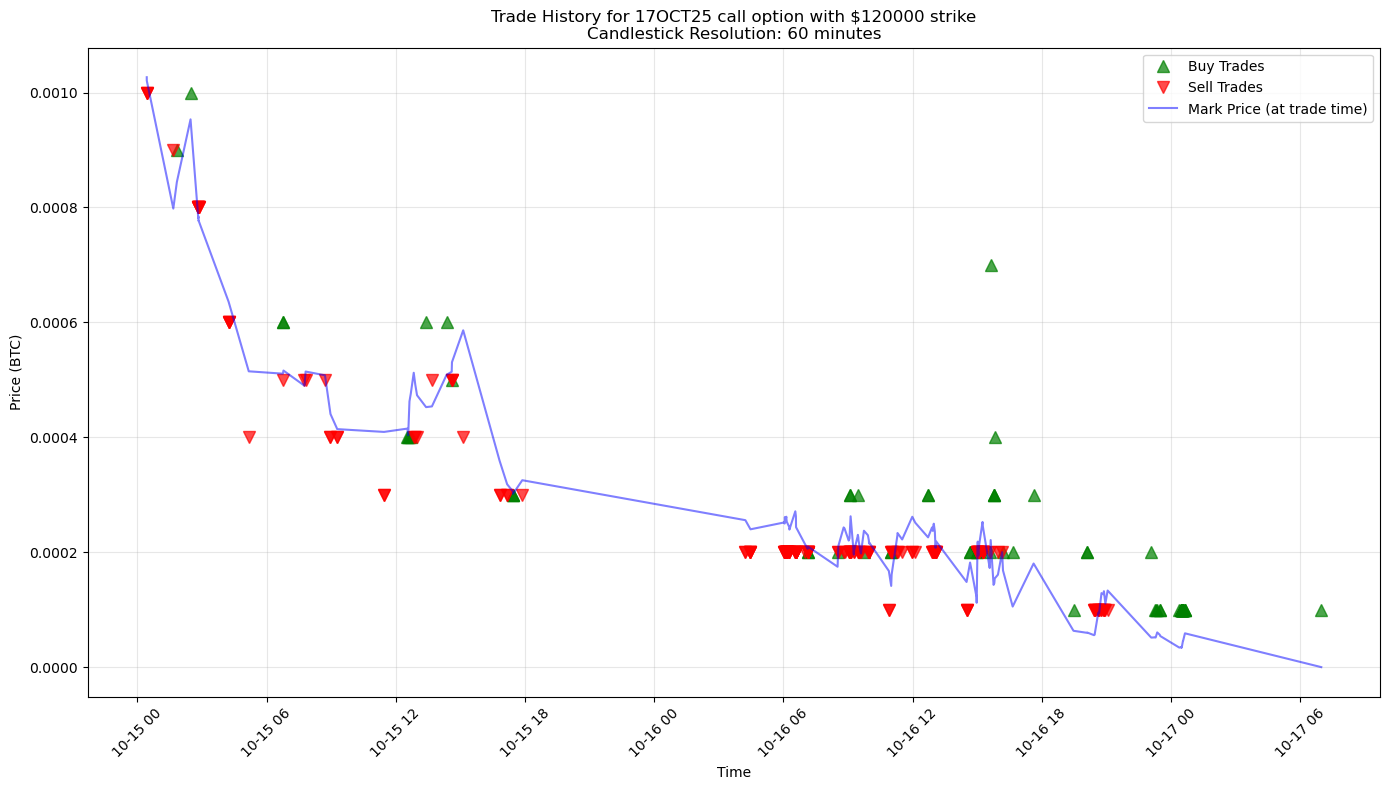

In [ ]:
# Plot prices
def plot_prices(df, strike, option_type, start_time, end_time, resolution="5"):
    """
    Plot trade history with candlestick data for an option.
    
    Parameters:
    - df: DataFrame with trade data
    - strike: Strike price
    - option_type: 'C' for call, 'P' for put
    - start_time: Start timestamp in milliseconds
    - end_time: End timestamp in milliseconds
    - resolution: Candlestick resolution in minutes (default "5")
    """
    # Filter trades for the specific option
    trades_df = df[(df['strike'] == strike) & (df['option_type'] == option_type)]
    trades_df = trades_df[(trades_df['timestamp'] >= start_time) & (trades_df['timestamp'] <= end_time)]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot trades
    if len(trades_df) > 0:
        buy_trades = trades_df[trades_df['direction'] == 'buy']
        sell_trades = trades_df[trades_df['direction'] == 'sell']
        
        if len(buy_trades) > 0:
            ax.plot(pd.to_datetime(buy_trades['timestamp'], unit='ms'), 
                   buy_trades['price'], 'g^', markersize=8, label='Buy Trades', alpha=0.7)
        
        if len(sell_trades) > 0:
            ax.plot(pd.to_datetime(sell_trades['timestamp'], unit='ms'),
                   sell_trades['price'], 'rv', markersize=8, label='Sell Trades', alpha=0.7)
        
        # Plot mark price as a line
        ax.plot(pd.to_datetime(trades_df['timestamp'], unit='ms'), 
               trades_df['mark_price'], 'b-', linewidth=1.5, label='Mark Price (at trade time)', alpha=0.5)
    
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Price (BTC)')
    plt.xticks(rotation=45)
    plt.title(f'Trade History for {expiry_date} {"call" if option_type == "C" else "put"} option with ${strike} strike\n' +
             f'Candlestick Resolution: {resolution} minute{"s" if resolution != "1" else ""}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

start_time = int(datetime(2025, 10, 15).timestamp() * 1000)
end_time = int(datetime(2025, 10, 18).timestamp() * 1000)
plot_prices(filtered_df, 120000, 'C', start_time, end_time, resolution="60")